In [2]:
#import needed Python libraries
import numpy as np
import random
import pandas as pd
import pylab
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from IPython.display import display

import matplotlib.pyplot as plt
%matplotlib inline

#graphics parameters of the notebook
# display graphs inline



# Make graphs prettier
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 400)
pd.set_option('plotting.matplotlib.register_converters', True)

# Make the fonts bigger
plt.rc('figure', figsize=(14, 7))
plt.rc('font', family='normal', weight='bold', size=15)

#inegrate data from 2009-2010 to 2018-2019 seasons from different files
data_18_19 = pd.read_csv("./data/2018_2019.csv", parse_dates=True)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
data_17_18 = pd.read_csv("./data/2017_2018.csv", parse_dates=True)
data_16_17 = pd.read_csv("./data/2016_2017.csv", parse_dates=True)
data_15_16 = pd.read_csv("./data/2015_2016.csv", parse_dates=True)
data_14_15 = pd.read_csv("./data/2014_2015.csv", parse_dates=True)
data_13_14 = pd.read_csv("./data/2013_2014.csv", parse_dates=True)
data_12_13 = pd.read_csv("./data/2012_2013.csv", parse_dates=True)
data_11_12 = pd.read_csv("./data/2011_2012.csv", parse_dates=True)
data_10_11 = pd.read_csv("./data/2010_2011.csv", parse_dates=True)
data_09_10 = pd.read_csv("./data/2009_2010.csv", parse_dates=True)
data_08_09 = pd.read_csv("./data/2008_2009.csv", parse_dates=True)

#test about data consistency for all files
for df in [data_18_19, data_17_18, data_16_17, data_15_16, data_14_15, data_13_14, data_12_13, data_11_12, data_10_11, data_09_10, data_08_09]:
    print("Number of df columns : " + str(len(data_18_19.columns)))

#integrate data in a single df
raw_data = pd.concat([data_18_19, data_17_18, data_16_17, data_15_16, data_14_15, data_13_14, data_12_13, data_11_12, data_10_11, data_09_10, data_08_09])

print(raw_data)


Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
Number of df columns : 62
    17Div      Date      HomeTeam        AwayTeam  FTHG  FTAG FTR  ...  GBA   BSH  BSD   BSA   SBH  SBD   SBA
0      E0  10/08/18    Man United       Leicester     2     1   H  ...  NaN   NaN  NaN   NaN   NaN  NaN   NaN
1      E0  11/08/18   Bournemouth         Cardiff     2     0   H  ...  NaN   NaN  NaN   NaN   NaN  NaN   NaN
2      E0  11/08/18        Fulham  Crystal Palace     0     2   A  ...  NaN   NaN  NaN   NaN   NaN  NaN   NaN
3      E0  11/08/18  Huddersfield         Chelsea     0     3   A  ...  NaN   NaN  NaN   NaN   NaN  NaN   NaN
4      E0  11/08/18     Newcastle       Tottenham     1     2   A  ...  NaN   NaN  NaN   NaN   NaN  NaN   NaN
..    ...       ...           ...             ...   ..

In [3]:
# for maipulation
#Select useful features for data visualization and analysis purposes

E0_data = raw_data[["Date", "HomeTeam", "AwayTeam", "FTHG", "FTAG", "FTR", "HTAG"]]

#convert date format to YYYY-MM-DD classic format
E0_data.Date = E0_data.Date.map(lambda x : "20" + x[6:8] + "-" + x[3:5] + "-" + x[0:2])
print(E0_data.Date)
#sort data by date
E0_data.sort_values('Date', inplace=True)

#reset data indexes
E0_data = E0_data.reset_index(drop=True)

#create matchID column
E0_data['matchID'] = E0_data.index


#create season feature
E0_data['Season'] = 0
E0_data.Season = E0_data.Date.map(lambda x : int(x[0:4]) if int(x[5:7]) > 6 else int(x[0:4]) - 1)

#null values test
E0_data.isnull().any()


#create teams list
teams = E0_data['HomeTeam'].unique()
print(teams)

#create seasons list
seasons = np.sort(E0_data['Season'].unique())
print(seasons)

#match day feature construction for HomeTeam and AwayTeam (1st match of a season --> 1, last --> 38 because 20 team play by season)
E0_HT_grpby = E0_data.groupby('HomeTeam')[['Date']]
E0_AT_grpby = E0_data.groupby('AwayTeam')[['Date']]

def fxyH(row):
    x = row['HomeTeam']
    y = row['Date']
    df1 = E0_HT_grpby.get_group(x)
    df2 = E0_AT_grpby.get_group(x)
    df1 = df1[df1['Date'] < y]
    df2 = df2[df2['Date'] < y]
    day = (1 + len(df1) + len(df2)) % 38
    return 38 if day == 0 else day 

def fxyA(row):
    x = row['AwayTeam']
    y = row['Date']
    df1 = E0_HT_grpby.get_group(x)
    df2 = E0_AT_grpby.get_group(x)
    df1 = df1[df1['Date'] < y]
    df2 = df2[df2['Date'] < y]
    day = (1 + len(df1) + len(df2)) % 38
    return 38 if day == 0 else day 

E0_data['HomeTeamDay'] = E0_data.apply(fxyH, axis=1)
E0_data['AwayTeamDay'] = E0_data.apply(fxyA, axis=1)

def resultConverter(A):
    if A == 'H':
        return 'W'
    elif A =='A':
        return 'L'
    else:
        return 'D'

def resultInverser(A):
    if A == 'W':
        return 'L'
    elif A == 'L':
        return 'W'
    else:
        return 'D'
def ordinalResultConverter(A):
    if A == 'W':
        return 1
    elif A == 'L':
        return 0
    else:
        return 0.5


    #make dummies variables for FTR (result of match), HW = Home Win, AW = Away Win, D = draw
E0_data['HW'] = E0_data.FTR.map(lambda x : 1 if x == 'H' else 0)
E0_data['AW'] = E0_data.FTR.map(lambda x : 1 if x == 'A' else 0)
E0_data['D']= E0_data.FTR.map(lambda x : 1 if x == 'D' else 0)

#make 2 different variable for the result of a match : 1 for the home team point of view, the other for the away team pt of view
E0_data['HR'] = E0_data.FTR.map(lambda x : resultConverter(x))
E0_data['AR'] = E0_data.HR.map(lambda x : resultInverser(x))

#make ordinal variable for the home team point of view result (1 = win, 0.5 = Draw, 0 = loss)
E0_data['ordinalHR'] = E0_data.HR.map(lambda x : ordinalResultConverter(x))

0      2018-08-10
1      2018-08-11
2      2018-08-11
3      2018-08-11
4      2018-08-11
          ...    
375    2009-05-24
376    2009-05-24
377    2009-05-24
378    2009-05-24
379    2009-05-24
Name: Date, Length: 4180, dtype: object
['Arsenal' 'Bolton' 'Everton' 'Hull' 'Middlesbrough' 'Sunderland'
 'West Ham' 'Chelsea' 'Aston Villa' 'Man United' 'Liverpool' 'Newcastle'
 'Tottenham' 'West Brom' 'Blackburn' 'Fulham' 'Stoke' 'Man City' 'Wigan'
 'Portsmouth' 'Wolves' 'Birmingham' 'Burnley' 'Blackpool' 'QPR' 'Swansea'
 'Norwich' 'Reading' 'Southampton' 'Crystal Palace' 'Cardiff' 'Leicester'
 'Bournemouth' 'Watford' 'Brighton' 'Huddersfield']
[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018]


c:\users\amada\pycharmprojects\cs230dlproject\venv\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
c:\users\amada\pycharmprojects\cs230dlproject\venv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [4]:
# feature extraction 
grp_by_HT = E0_data.groupby('HomeTeam')
grp_by_AT = E0_data.groupby('AwayTeam')

#past performance features engineering
for team in teams:
    
    #we retrieve results series of the team
    teamHomeResults_s = grp_by_HT.get_group(team)['HR']
    teamAwayResults_s = grp_by_AT.get_group(team)['AR']
    #combine these 2 series and sort the obtained serie
    teamResults_s = pd.concat([teamHomeResults_s, teamAwayResults_s]).sort_index()

    #(i) compute k_last_HR and k_last_AR --> 6 features
    lag1TeamResults_d = teamResults_s.shift(1).to_dict()
    lag2TeamResults_d = teamResults_s.shift(2).to_dict()
    lag3TeamResults_d = teamResults_s.shift(3).to_dict()
    
    #k_last_HTR and k_last_ATR are just shifted versions of the results series
    E0_data.loc[teamHomeResults_s.index,'1_last_HTR'] = E0_data.loc[teamHomeResults_s.index,:].index.map(lambda x : lag1TeamResults_d[x])
    E0_data.loc[teamHomeResults_s.index,'2_last_HTR'] = E0_data.loc[teamHomeResults_s.index,:].index.map(lambda x : lag2TeamResults_d[x])
    E0_data.loc[teamHomeResults_s.index,'3_last_HTR'] = E0_data.loc[teamHomeResults_s.index,:].index.map(lambda x : lag3TeamResults_d[x])
    E0_data.loc[teamAwayResults_s.index,'1_last_ATR'] = E0_data.loc[teamAwayResults_s.index,:].index.map(lambda x : lag1TeamResults_d[x])
    E0_data.loc[teamAwayResults_s.index,'2_last_ATR'] = E0_data.loc[teamAwayResults_s.index,:].index.map(lambda x : lag2TeamResults_d[x])
    E0_data.loc[teamAwayResults_s.index,'3_last_ATR'] = E0_data.loc[teamAwayResults_s.index,:].index.map(lambda x : lag3TeamResults_d[x])
    
    #(ii) Compute k_last_HTRH and k_last ATAR --> 4 features
    #we need here to diferentiate home results and past results. Python dictionaries allows the program to access to
    #needed data faster than with a Pandas serie
    lag1TeamHomeResults_d = teamHomeResults_s.shift(1).to_dict()
    lag2TeamHomeResults_d = teamHomeResults_s.shift(2).to_dict()
    lag1TeamAwayResults_d = teamAwayResults_s.shift(1).to_dict()
    lag2TeamAwayResults_d = teamAwayResults_s.shift(2).to_dict()
    
    E0_data.loc[teamHomeResults_s.index,'1_last_HTHR'] = E0_data.loc[teamHomeResults_s.index,:].index.map(lambda x : lag1TeamHomeResults_d[x])
    E0_data.loc[teamHomeResults_s.index,'2_last_HTHR'] = E0_data.loc[teamHomeResults_s.index,:].index.map(lambda x : lag2TeamHomeResults_d[x])
    E0_data.loc[teamAwayResults_s.index,'1_last_ATAR'] = E0_data.loc[teamAwayResults_s.index,:].index.map(lambda x : lag1TeamAwayResults_d[x])
    E0_data.loc[teamAwayResults_s.index,'2_last_ATAR'] = E0_data.loc[teamAwayResults_s.index,:].index.map(lambda x : lag2TeamAwayResults_d[x])
    
    #(iii) rates based features : we need to get only season specific results series (to avoid taking previous season results into season rates)
    for season in seasons:
        
        #retrieve season specific results serie (1 win serie, 1 draw serie the loss  will be computed thanks to
        #the 2 others)
        teamHomeResultsW_s = grp_by_HT.get_group(team)['HW']
        teamAwayResultsW_s = grp_by_AT.get_group(team)['AW']
        teamResultsW_s = pd.concat([teamHomeResultsW_s, teamAwayResultsW_s]).sort_index()

        teamHomeResultsD_s = grp_by_HT.get_group(team)['D']
        teamAwayResultsD_s = grp_by_AT.get_group(team)['D']
        teamResultsD_s = pd.concat([teamHomeResultsD_s, teamAwayResultsD_s]).sort_index()
        
        #(i) compute 7_HTW_rate, 12_HTW_rate, 7_HTD_rate, 12_HTD_rate, 7_ATW_rate, 12_ATW_rate, 7_ATD_rate, 12_ATD_rate --> 8 features
        win7TeamResultsW_d = teamResultsW_s.shift(1).rolling(window = 7, min_periods = 5).mean().to_dict()
        win12TeamResultsW_d = teamResultsW_s.shift(1).rolling(window = 12, min_periods = 8).mean().to_dict()
        win7TeamResultsD_d = teamResultsD_s.shift(1).rolling( window = 7, min_periods = 5).mean().to_dict()
        win12TeamResultsD_d = teamResultsD_s.shift(1).rolling( window = 12, min_periods = 8).mean().to_dict()
        
        E0_data.loc[teamHomeResultsW_s.index,'7_HTW_rate'] = E0_data.loc[teamHomeResultsW_s.index,:].index.map(lambda x : win7TeamResultsW_d[x])
        E0_data.loc[teamHomeResultsW_s.index,'12_HTW_rate'] = E0_data.loc[teamHomeResultsW_s.index,:].index.map(lambda x : win12TeamResultsW_d[x])
        E0_data.loc[teamAwayResultsW_s.index,'7_ATW_rate'] = E0_data.loc[teamAwayResultsW_s.index,:].index.map(lambda x : win7TeamResultsW_d[x])
        E0_data.loc[teamAwayResultsW_s.index,'12_ATW_rate'] = E0_data.loc[teamAwayResultsW_s.index,:].index.map(lambda x : win12TeamResultsW_d[x])
        
        E0_data.loc[teamHomeResultsD_s.index,'7_HTD_rate'] = E0_data.loc[teamHomeResultsD_s.index,:].index.map(lambda x : win7TeamResultsD_d[x])
        E0_data.loc[teamHomeResultsD_s.index,'12_HTD_rate'] = E0_data.loc[teamHomeResultsD_s.index,:].index.map(lambda x : win12TeamResultsD_d[x])
        E0_data.loc[teamAwayResultsD_s.index,'7_ATD_rate'] = E0_data.loc[teamAwayResultsD_s.index,:].index.map(lambda x : win7TeamResultsD_d[x])
        E0_data.loc[teamAwayResultsD_s.index,'12_ATD_rate'] = E0_data.loc[teamAwayResultsD_s.index,:].index.map(lambda x : win12TeamResultsD_d[x])

        #(ii) compute 5_HTHW_rate and 5_ATAW_rate
        win5TeamResultsHomeW_d = teamHomeResultsW_s.shift(1).rolling( window = 5, min_periods = 3).mean().to_dict()
        win5TeamResultsAwayW_d = teamAwayResultsW_s.shift(1).rolling( window = 5, min_periods = 3).mean().to_dict()
        E0_data.loc[teamHomeResultsW_s.index,'5_HTHW_rate'] = E0_data.loc[teamHomeResultsW_s.index,:].index.map(lambda x : win5TeamResultsHomeW_d[x])
        E0_data.loc[teamAwayResultsW_s.index,'5_ATAW_rate'] = E0_data.loc[teamAwayResultsW_s.index,:].index.map(lambda x : win5TeamResultsAwayW_d[x])

#compute missing features k_XTL_rate thanks to the k_XTW_rate and k_XTD_rate features
E0_data.loc[:,'7_HTL_rate'] = 1 - (E0_data['7_HTW_rate'] + E0_data['7_HTD_rate'])
E0_data.loc[:,'12_HTL_rate'] = 1 - (E0_data['7_HTW_rate'] + E0_data['7_HTD_rate'])
E0_data.loc[:,'7_ATL_rate'] = 1 - (E0_data['7_ATW_rate'] + E0_data['7_ATD_rate'])
E0_data.loc[:,'12_ATL_rate'] = 1 - (E0_data['7_ATW_rate'] + E0_data['7_ATD_rate'])

print(E0_data.loc[:,'12_ATL_rate'])

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
4175    0.428571
4176    0.142857
4177    0.285714
4178    0.857143
4179    0.857143
Name: 12_ATL_rate, Length: 4180, dtype: float64


In [5]:
#Elo ranking method parameters
k = 20.0
d = 400.0
c = 10.0

#Initialization of output containers
ELO_dict = dict()
gammaHT_dict = dict()
gammaAT_dict = dict()

#intermediate data containers initilization
latest_update_d = dict() #contains latest updates in date of ELO_dict
prev_ELO_score_d = dict() #contains latest ELO_score given to a team for computing new one

prev_season_teams = [team for team in teams] #contains list of teams for the current season
last_teams_ELO_av = 0.0 #contains mean of last

for team in teams:
    latest_update_d[team] = '2008-01-01'
    prev_ELO_score_d[team] = 0.0

for season in E0_data.Season.unique():
    season_match_dates = E0_data[E0_data['Season'] == season].Date.unique()
    season_teams = E0_data[E0_data['Season'] == season].HomeTeam.unique()
    last_season_date = season_match_dates[len(season_match_dates) - 1]
    
    for Steam in season_teams:
        if not (Steam in prev_season_teams):
            prev_ELO_score_d[Steam] = last_teams_ELO_av
            
    for date in season_match_dates:
        for team in teams:
            if not ((team in E0_data[E0_data['Date'] == date]['HomeTeam'].values) | (team in E0_data[E0_data['Date'] == date]['AwayTeam'].values)):
                ELO_dict[(team, date)] = prev_ELO_score_d[team]
                latest_update_d[team] = date
            else:
                if latest_update_d[team] < date:
                    Hteam = E0_data[(E0_data['Date'] == date) & ((E0_data['HomeTeam'] == team) | (E0_data['AwayTeam'] == team))]['HomeTeam'].values[0]
                    Ateam = E0_data[(E0_data['Date'] == date) & ((E0_data['HomeTeam'] == team) | (E0_data['AwayTeam'] == team))]['AwayTeam'].values[0]
            
                    l0H = prev_ELO_score_d[Hteam]
                    l0A = prev_ELO_score_d[Ateam]
                    gammaH = 1.0/(1.0 + c**((l0A - l0H)/d))
                    gammaA = 1.0 - gammaH
                    alphaH = E0_data[(E0_data['Date'] == date) & (E0_data['HomeTeam'] == Hteam)]['ordinalHR'].values[0]
                    alphaA = 1 - alphaH
            
                    #compute new scores
                    new_HT_ELO_score = l0H + k * (alphaH - gammaH)
                    new_AT_ELO_score = l0A + k * (alphaA - gammaA)

                    #put new scores in ELO_dict
                    ELO_dict[(Hteam, date)] = new_HT_ELO_score
                    ELO_dict[(Ateam, date)] = new_AT_ELO_score
                    gammaHT_dict[(Hteam, date)] = gammaH
                    gammaAT_dict[(Ateam, date)] = gammaA
                    latest_update_d[Hteam] = date
                    latest_update_d[Ateam] = date
            
                    #update prev_ELO_score_d and latest_update_d
                    prev_ELO_score_d[Hteam] = new_HT_ELO_score
                    prev_ELO_score_d[Ateam] = new_AT_ELO_score
        
        if date == last_season_date:
            ELOs = np.array([prev_ELO_score_d[Steam] for Steam in season_teams])
            ELOs.sort()
            last_teams_ELO_av = np.mean(ELOs[0:-16])
            prev_season_teams = season_teams
            
 #make HTeamEloScore, ATeamEloScore and gammaHome features from previously computed dictionaries

def HomeTeamEloScore(row):
    return ELO_dict[(row['HomeTeam'], row['Date'])]

def AwayTeamEloScore(row):
    return ELO_dict[(row['AwayTeam'], row['Date'])]

def gammaHTeamDate(row):
    return gammaHT_dict[(row['HomeTeam'], row['Date'])]

E0_data.loc[:,'HTeamEloScore'] = E0_data.apply(HomeTeamEloScore, axis=1) 
E0_data.loc[:,'ATeamEloScore'] = E0_data.apply(AwayTeamEloScore, axis=1) 
E0_data.loc[:,'gammaHome'] = E0_data.apply(gammaHTeamDate, axis=1)  
print (E0_data.loc[:,'gammaHome'])

0       0.500000
1       0.500000
2       0.500000
3       0.500000
4       0.500000
          ...   
4175    0.365963
4176    0.306048
4177    0.806904
4178    0.816314
4179    0.703904
Name: gammaHome, Length: 4180, dtype: float64


In [6]:
#feature extraction 
for team in teams:
    homeMatchDates_s = E0_data[E0_data['HomeTeam'] == team]['Date']
    awayMatchDates_s = E0_data[E0_data['AwayTeam'] == team]['Date']
    matchDates_s = pd.concat([homeMatchDates_s, awayMatchDates_s]).sort_index()
    lastMatchDates_s = matchDates_s.shift(1)
    matchDates = matchDates_s.values
        
    E0_data.loc[E0_data['HomeTeam'] == team, 'HTLastMatchDate'] = E0_data.loc[E0_data['HomeTeam'] == team].index.map(lambda x : lastMatchDates_s[x])
    E0_data.loc[E0_data['AwayTeam'] == team, 'ATLastMatchDate'] = E0_data.loc[E0_data['AwayTeam'] == team].index.map(lambda x : lastMatchDates_s[x])
    
def HTdaysBetweenDates(row):
    if not (pd.isnull(row['HTLastMatchDate'])):
        currDate = pd.to_datetime(row['Date'])
        prevDate = pd.to_datetime(row['HTLastMatchDate'])
        ndays = (currDate - prevDate).days 
        if ndays < 20:
            return ndays
        else: 
            return np.nan
    else:
        return np.nan 
    
def ATdaysBetweenDates(row):
    if not (pd.isnull(row['ATLastMatchDate'])):
        currDate = pd.to_datetime(row['Date'])
        prevDate = pd.to_datetime(row['ATLastMatchDate'])
        return (currDate - prevDate).days
    else:
        return np.nan 
    
E0_data.loc[:, 'HTdaysSinceLastMatch'] = E0_data.apply(HTdaysBetweenDates, axis=1)
E0_data.loc[:, 'ATdaysSinceLastMatch'] = E0_data.apply(ATdaysBetweenDates, axis=1)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


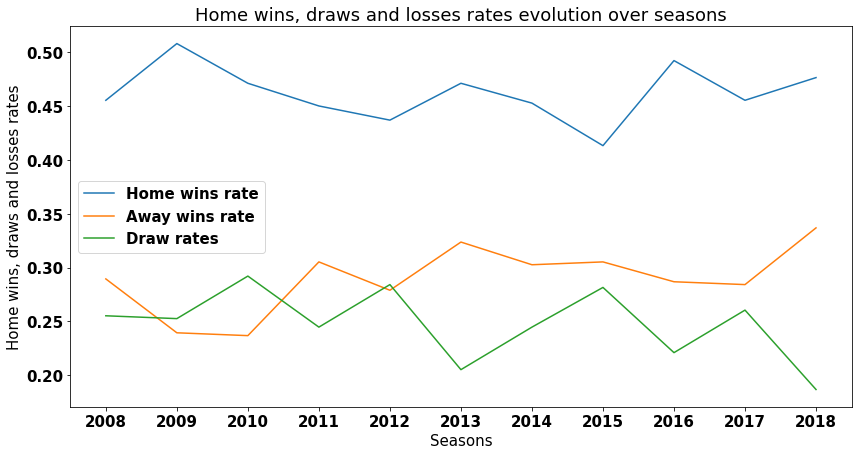

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Conclusion : these histograms show a slight correlation between last or 2nd last home/away team results and current next home result. Nevertheless, when this past result (away or home) is a draw, results repartition is significantly close to the global repartition


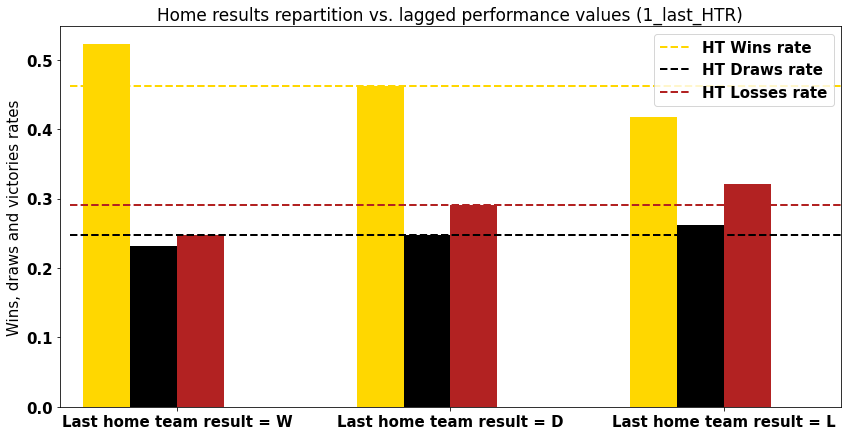

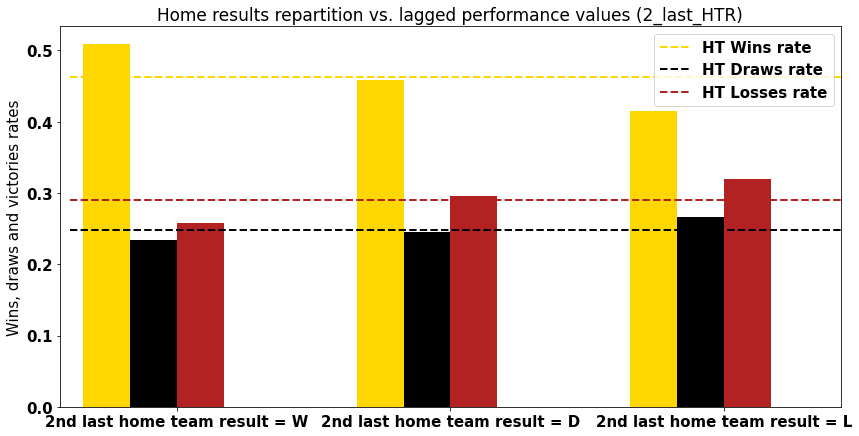

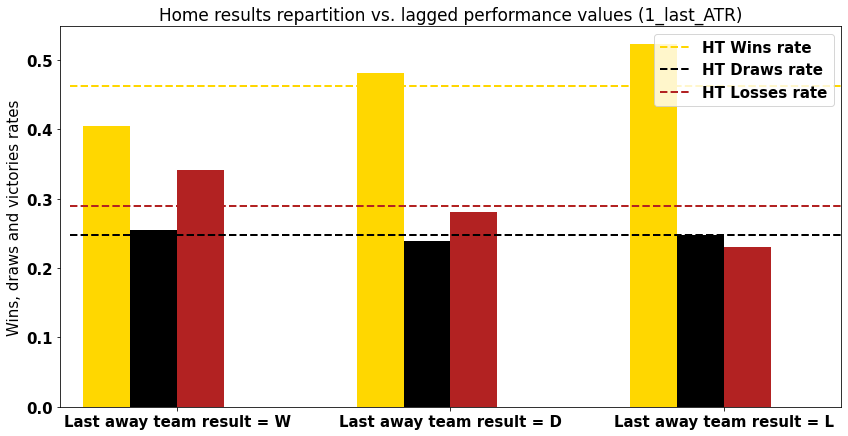

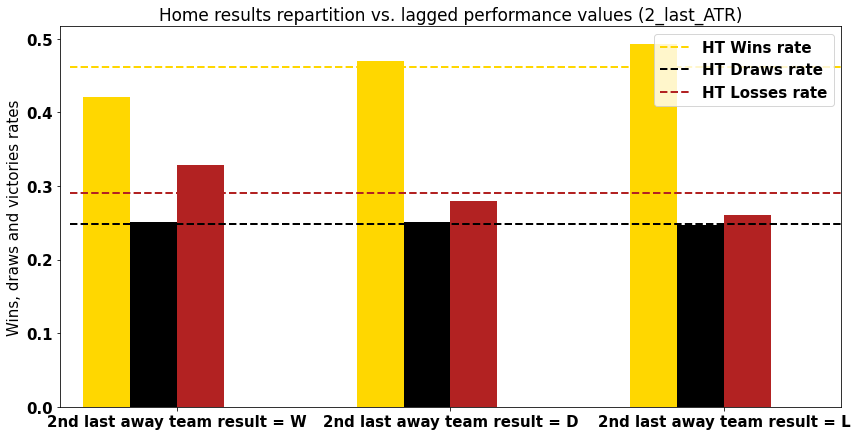

In [7]:
# for analysis and visualisation 
#Home wins, Away wins and draws rates variations over seasons
HW_rates = []
AW_rates = []
D_rates = []

for season in seasons:
    season_data = E0_data[E0_data['Season'] == season]
    total_matches_nb = len(season_data.index)
    HW_rate = float(len(season_data[season_data['FTR'] == 'H'].index))/float(total_matches_nb)
    AW_rate = float(len(season_data[season_data['FTR'] == 'A'].index))/float(total_matches_nb)
    D_rate = float(len(season_data[season_data['FTR'] == 'D'].index))/float(total_matches_nb)
    HW_rates.append(HW_rate)
    AW_rates.append(AW_rate)
    D_rates.append(D_rate)

plt.figure()
plt.plot(seasons, HW_rates, label="Home wins rate")
plt.plot(seasons, AW_rates, label="Away wins rate")
plt.plot(seasons, D_rates, label="Draw rates")
plt.legend()
plt.xticks([int(season) for season in seasons], seasons)
plt.xlabel("Seasons")
plt.ylabel("Home wins, draws and losses rates")
plt.title("Home wins, draws and losses rates evolution over seasons")

plt.show()


#global wins, draws and losses rates
HW_rate = float(len(E0_data[E0_data['HR'] == 'W'].index))/float(len(E0_data.index))
HL_rate = float(len(E0_data[E0_data['HR'] == 'L'].index))/float(len(E0_data.index))
HD_rate = float(len(E0_data[E0_data['HR'] == 'D'].index))/float(len(E0_data.index))
rates = [HW_rate, HL_rate, HD_rate]

width = 0.12
xticks = np.array([0.3, 1.0, 1.7])
xticksLabels = ['0.0 - 0.2', '0.2 - 0.4', '0.4 - 0.6']
xlabels = [["Last home team result = W", "Last home team result = D", "Last home team result = L"],
           ["2nd last home team result = W", "2nd last home team result = D", "2nd last home team result = L"],
           ["Last away team result = W", "Last away team result = D", "Last away team result = L"],
            ["2nd last away team result = W", "2nd last away team result = D", "2nd last away team result = L"]]

var_names = ['1_last_HTR', '2_last_HTR', '1_last_ATR', '2_last_ATR']
titles = ["Home results repartition vs. lagged performance values (" + var_name + ")" for var_name in var_names]

k=0
for var_name in var_names:
    
    fig = plt.figure()
    HW_rates = []
    HD_rates = []
    
    for Rvalue in ['W','D','L']:
        HW_rates.append(len(E0_data[(E0_data[var_name] == Rvalue) & (E0_data['HR'] == 'W')].index) / len(E0_data[E0_data[var_name] == Rvalue].index))
        HD_rates.append(len(E0_data[(E0_data[var_name] == Rvalue) & (E0_data['HR'] == 'D')].index) / len(E0_data[E0_data[var_name] == Rvalue].index))
    
    HL_rates = [1 - (HW_rate + HD_rate) for (HW_rate, HD_rate) in zip(HW_rates, HD_rates)]
    
    plt.bar(xticks - 1.5 * width, HW_rates, width, color = 'gold' )
   
    plt.bar(xticks - 0.5 * width, HD_rates, width, color = 'k')
   
    plt.bar(xticks + 0.5 * width, HL_rates, width, color = 'firebrick')
   
    plt.plot((0.025, 2.0), (HW_rate, HW_rate), '--', color='gold', linewidth=2)
    plt.plot((0.025, 2.0), (HD_rate, HD_rate), '--', color='k', linewidth=2)
    plt.plot((0.025, 2.0), (HL_rate, HL_rate), '--', color='firebrick', linewidth=2)
    
    pylab.xticks(xticks, xlabels[k])
    plt.ylabel("Wins, draws and victories rates")
    plt.legend(["HT Wins rate", "HT Draws rate", "HT Losses rate"])
    plt.xlim(0.0, 2.0)
    plt.title(titles[k], fontsize=17)

    k += 1

print("Conclusion : these histograms show a slight correlation between last or 2nd last home/away team results and current next home result. Nevertheless, when this past result (away or home) is a draw, results repartition is significantly close to the global repartition")



Text(0.5, 1.0, 'Elo score distribution histogram')

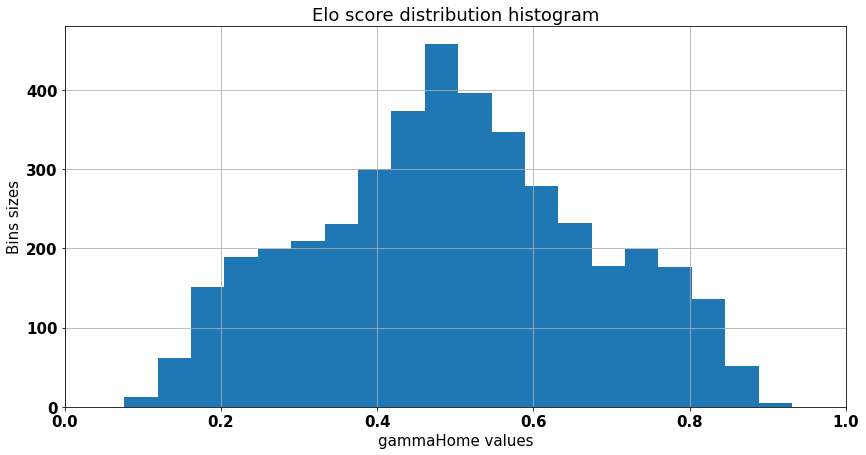

In [8]:
plt.hist(E0_data['gammaHome'].values, bins=20)
plt.xlabel("gammaHome values")
plt.ylabel("Bins sizes")
plt.xlim(0,1)
plt.grid()
plt.title("Elo score distribution histogram")

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


 : it seems that at least 2 seasons are needed for teams Elo scores to get to their normal values range (2 seasons = 2 * 380 matches).


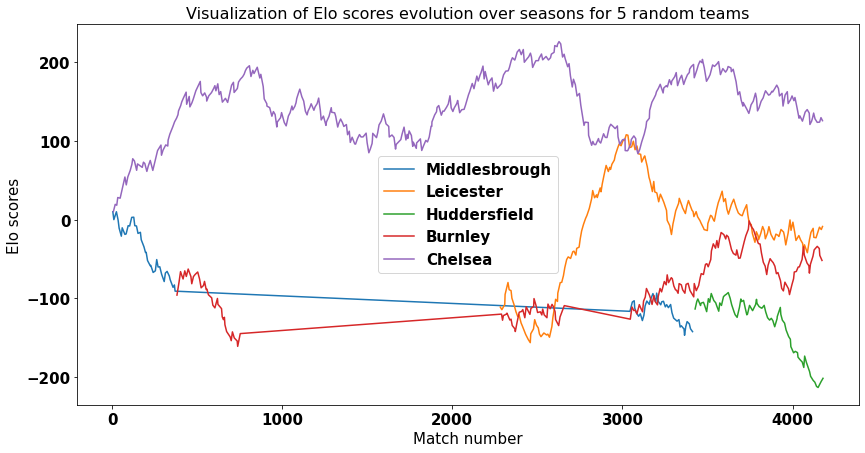

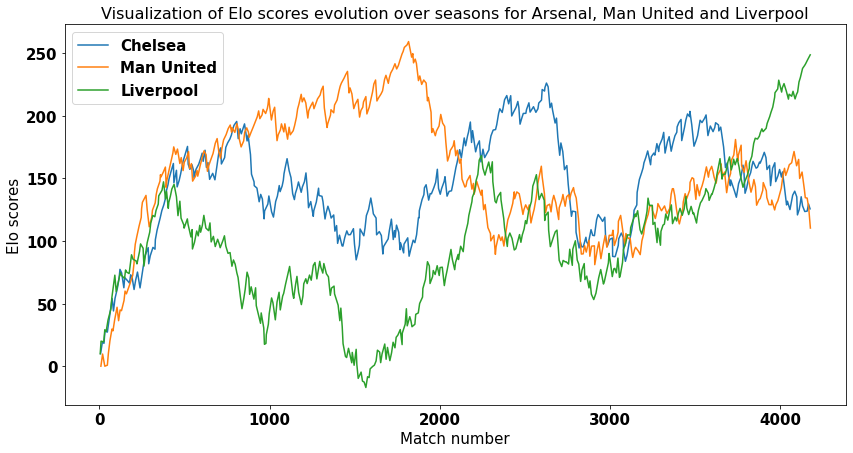

In [9]:
fig = plt.figure()
#random teams elo score visualization
random_teams = [teams[random.randint(0, len(teams))-1] for k in range(0,5)]
for team in random_teams:
    HomeEloScores = E0_data[E0_data['HomeTeam'] == team]['HTeamEloScore']
    AwayEloScores = E0_data[E0_data['AwayTeam'] == team]['ATeamEloScore']
    EloScores = pd.concat([HomeEloScores, AwayEloScores]).sort_index()
    EloScores.plot()
plt.legend(random_teams)
plt.xlabel('Match number')
plt.ylabel('Elo scores')
plt.title('Visualization of Elo scores evolution over seasons for 5 random teams', fontsize = 16)
    
fig = plt.figure()
for team in ['Chelsea', 'Man United', 'Liverpool', ]:
    HomeEloScores = E0_data[E0_data['HomeTeam'] == team]['HTeamEloScore']
    AwayEloScores = E0_data[E0_data['AwayTeam'] == team]['ATeamEloScore']
    EloScores = pd.concat([HomeEloScores, AwayEloScores]).sort_index()
    EloScores.plot()
plt.legend(['Chelsea', 'Man United', 'Liverpool'])
plt.xlabel('Match number')
plt.ylabel('Elo scores')
plt.title('Visualization of Elo scores evolution over seasons for Arsenal, Man United and Liverpool', fontsize=16)

print (" : it seems that at least 2 seasons are needed for teams Elo scores to get to their normal values range (2 seasons = 2 * 380 matches).")

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

#Create X and Y
X = pd.get_dummies(E0_data[['HomeTeam', 'AwayTeam', 'Season', 'HTeamEloScore', 'ATeamEloScore', 'HTdaysSinceLastMatch',
                            'ATdaysSinceLastMatch', 'gammaHome']])
Y = E0_data[['FTR']]

#X preprocessing
imputer = SimpleImputer()
X_imputed = imputer.fit_transform(X)

#Split X and Y into training and Test Sets
x_train, x_test, y_train, y_test = train_test_split(X_imputed, Y, shuffle=True)

#Logistic Regression Model Setup
model = LogisticRegression()
model.fit(x_train, y_train)

#Logistic Regression Model Metrics
print("Logestic Regression")
print("Train Score: ", model.score(x_train, y_train))
print("Test Score: ", model.score(x_test, y_test))
print(classification_report(y_test, model.predict(x_test), digits=3))

#Forest model setup
forest = RandomForestClassifier(n_estimators=8, random_state=2)
forest.fit(x_train, y_train)

#Forest Model Metrics
print("Forest Classifier")
print("Train Score: ", forest.score(x_train, y_train))
print("Test Score: ", forest.score(x_test, y_test))
print(classification_report(y_test, forest.predict(x_test), digits=3))

c:\users\amada\pycharmprojects\cs230dlproject\venv\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\amada\pycharmprojects\cs230dlproject\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\users\amada\pycharmprojects\cs230dlproject\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-sc

Logestic Regression
Train Score:  0.5748006379585326
Test Score:  0.5645933014354066
              precision    recall  f1-score   support

           A      0.542     0.609     0.574       307
           D      0.000     0.000     0.000       268
           H      0.576     0.857     0.689       470

    accuracy                          0.565      1045
   macro avg      0.373     0.489     0.421      1045
weighted avg      0.418     0.565     0.478      1045

Forest Classifier
Train Score:  0.9830940988835726
Test Score:  0.508133971291866
              precision    recall  f1-score   support

           A      0.500     0.550     0.524       307
           D      0.298     0.239     0.265       268
           H      0.606     0.634     0.620       470

    accuracy                          0.508      1045
   macro avg      0.468     0.474     0.470      1045
weighted avg      0.496     0.508     0.501      1045



c:\users\amada\pycharmprojects\cs230dlproject\venv\lib\site-packages\ipykernel_launcher.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
